In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta, gamma, halfnorm, laplace, norm, truncnorm
from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
import data_generator as dg

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


\begin{align*}
P(\theta | \text{Data}) &= \frac{P(\text{Data} | \theta) \cdot P(\theta)}{P(\text{Data})}
\end{align*}

| Package          | Language   | Developer       | Approach    |
|------------------|------------|-----------------|-------------|
| Robyn            | R          | Facebook        | Frequentist |
| pymc-marketing   | Python     | PyMC Labs       | Bayesian    |
| LightweightMMM   | Python     | Google          | Bayesian    |
| Meridian         | Python     | Google          | Bayesian    |


# 0) MMM data generator

In [2]:
np.random.seed(10)

# Set parameters for data generator
start_date = "2021-01-01"
periods = 52 * 3
channels = ["tv", "social", "search"]
adstock_alphas = [0.50, 0.25, 0.05]
saturation_lamdas = [1.5, 2.5, 3.5]
betas = [350, 150, 50]
spend_scalars = [10, 15, 20]

df = dg.data_generator(start_date, periods, channels, spend_scalars, adstock_alphas, saturation_lamdas, betas)

# Scale betas using maximum sales value - this is so it is comparable to the fitted beta from pymc (pymc does feature and target scaling using MaxAbsScaler from sklearn)
betas_scaled = [
    ((df["tv_sales"] / df["sales"].max()) / df["tv_saturated"]).mean(),
    ((df["social_sales"] / df["sales"].max()) / df["social_saturated"]).mean(),
    ((df["search_sales"] / df["sales"].max()) / df["search_saturated"]).mean()
]

# Calculate contributions
contributions = np.asarray([
    round((df["tv_sales"].sum() / df["sales"].sum()), 2),
    round((df["social_sales"].sum() / df["sales"].sum()), 2),
    round((df["search_sales"].sum() / df["sales"].sum()), 2),
    round((df["demand"].sum() / df["sales"].sum()), 2)
])

df[["date", "demand", "demand_proxy", "tv_spend_raw", "social_spend_raw", "search_spend_raw", "sales"]]

date      demand  demand_proxy  tv_spend_raw  social_spend_raw  \
0   2021-01-03  356.003195    330.831226   5501.441206       5894.908137   
1   2021-01-10  301.006385    317.461345   2507.942445       5791.555554   
2   2021-01-17   81.538923     89.223970   1049.661462       1081.642708   
3   2021-01-24  241.765941    169.729439   3008.937195       5323.913163   
4   2021-01-31  311.145259    349.047382   3171.490614       6830.642777   
..         ...         ...           ...           ...               ...   
151 2023-11-26  504.966471    517.052302   4065.830904      10716.104909   
152 2023-12-03  604.005118    633.299525   3740.575561       7287.215373   
153 2023-12-10  525.265482    438.144702   6442.185846      11242.173092   
154 2023-12-17  458.850104    581.817816   4555.589865       3870.492537   
155 2023-12-24  495.106526    440.470426   2637.616935       8490.789891   

     search_spend_raw       sales  
0         7182.864568  489.566208  
1         6312.367780  441.138691  
2         1429.740857  152.309451  
3         6185.584938  367.160745  
4         7227.783598  465.083840  
..                ...         ...  
151       9975.069784  743.618076  
152      16792.317339  822.314394  
153       6893.282177  763.558935  
154       6558.943829  646.468794  
155       6587.909768  680.397756  

[156 rows x 7 columns]

In [3]:
betas_scaled

[0.3301787308414177, 0.1415051703606076, 0.04716839012020252]

In [4]:
contributions

array([0.14, 0.11, 0.05, 0.7 ])

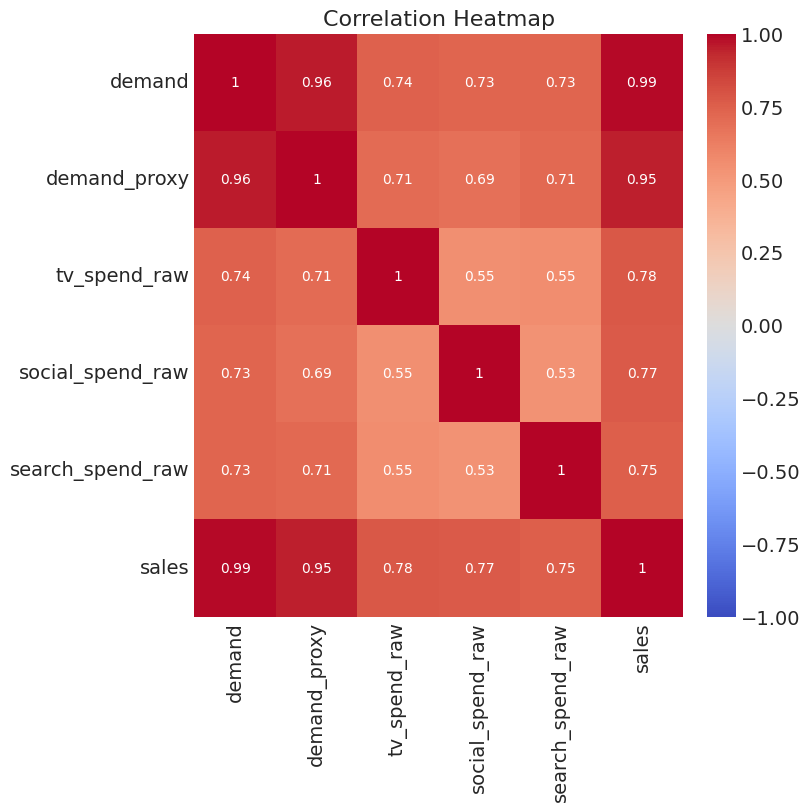

In [36]:
plt.figure(figsize=(8, 8))
sns.heatmap(df[["demand", "demand_proxy", "tv_spend_raw", "social_spend_raw", "search_spend_raw", "sales"]].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

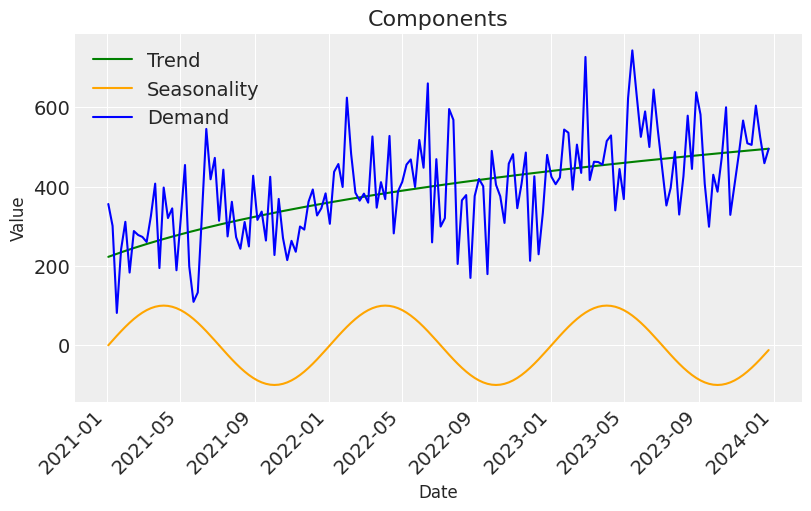

In [6]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['trend']*1000, label="Trend", color="green")
sns.lineplot(x=df['date'], y=df['seasonality']*1000, label="Seasonality", color="orange")
sns.lineplot(x=df['date'], y=df['demand'], label="Demand", color="blue")

plt.title('Components', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

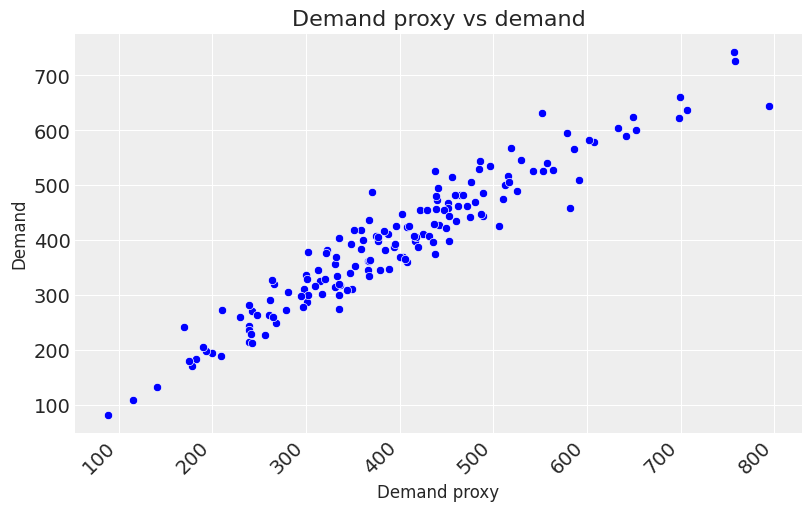

In [7]:
plt.figure(figsize=(8, 5))

sns.scatterplot(x=df['demand_proxy'], y=df['demand'], color="blue")

plt.title('Demand proxy vs demand', fontsize=16)
plt.xlabel('Demand proxy', fontsize=12)
plt.ylabel('Demand', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

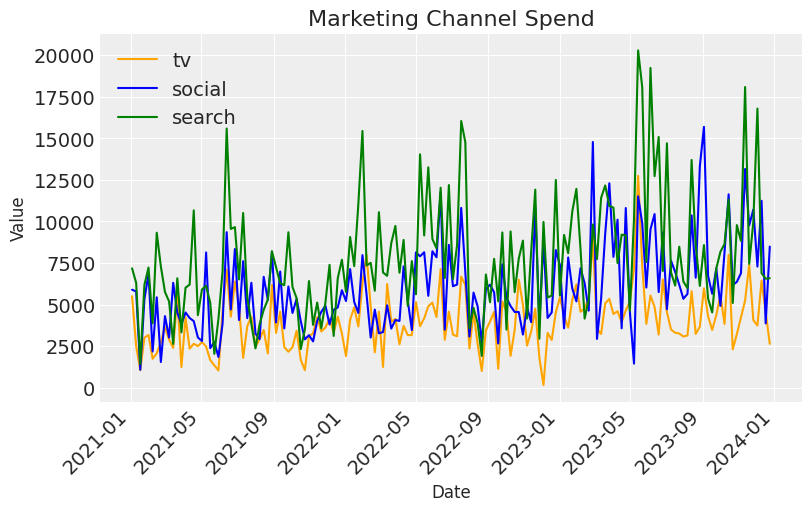

In [8]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['tv_spend_raw'], label=channels[0], color="orange")
sns.lineplot(x=df['date'], y=df['social_spend_raw'], label=channels[1], color="blue")
sns.lineplot(x=df['date'], y=df['search_spend_raw'], label=channels[2], color="green")
plt.title('Marketing Channel Spend', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

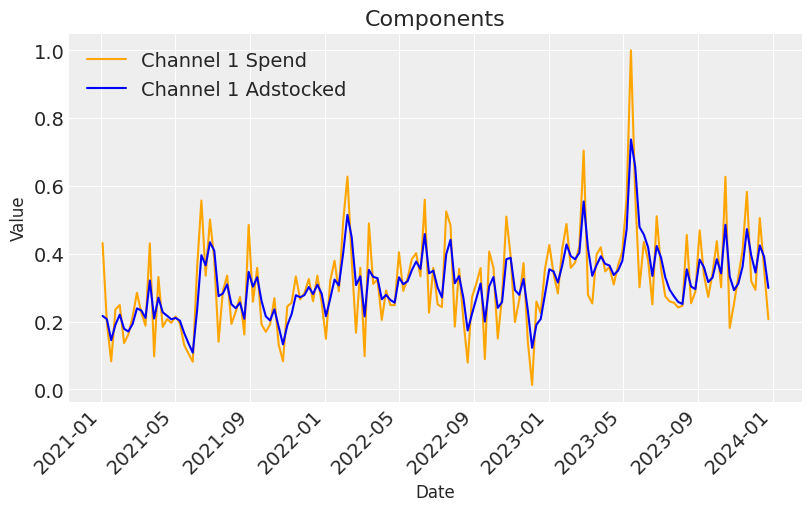

In [9]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['tv_spend'], label="Channel 1 Spend", color="orange")
sns.lineplot(x=df['date'], y=df['tv_adstock'], label="Channel 1 Adstocked", color="blue")

plt.title('Components', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

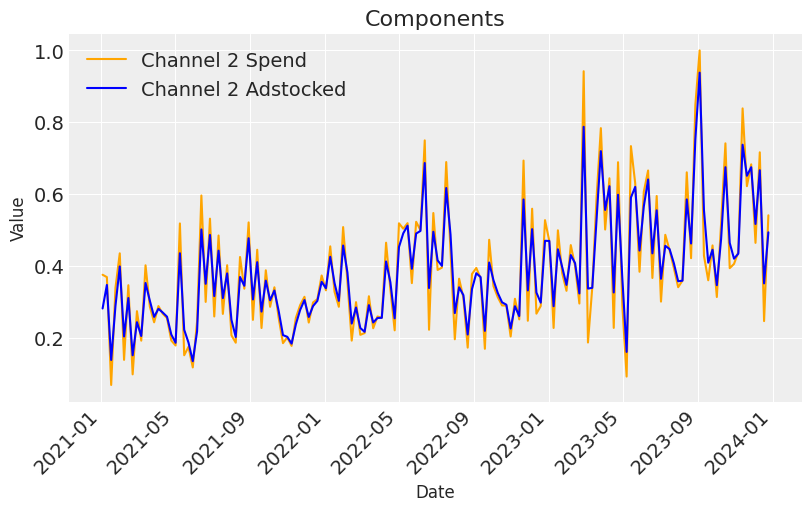

In [10]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['social_spend'], label="Channel 2 Spend", color="orange")
sns.lineplot(x=df['date'], y=df['social_adstock'], label="Channel 2 Adstocked", color="blue")

plt.title('Components', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

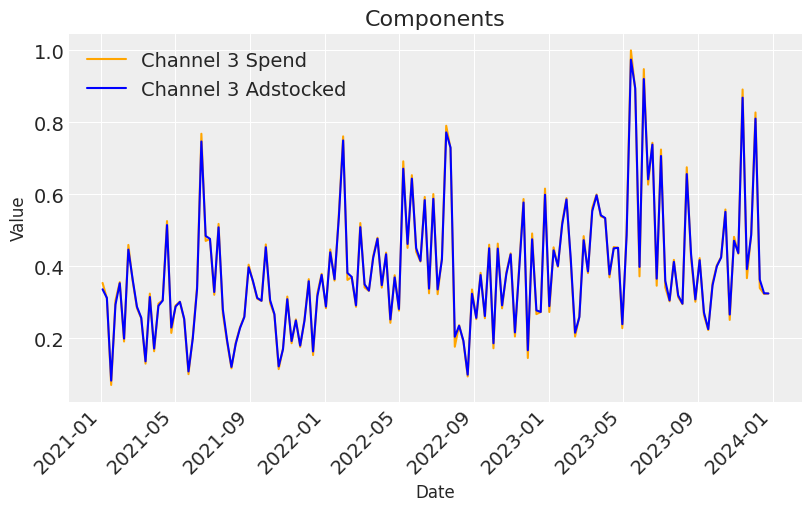

In [11]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['search_spend'], label="Channel 3 Spend", color="orange")
sns.lineplot(x=df['date'], y=df['search_adstock'], label="Channel 3 Adstocked", color="blue")

plt.title('Components', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

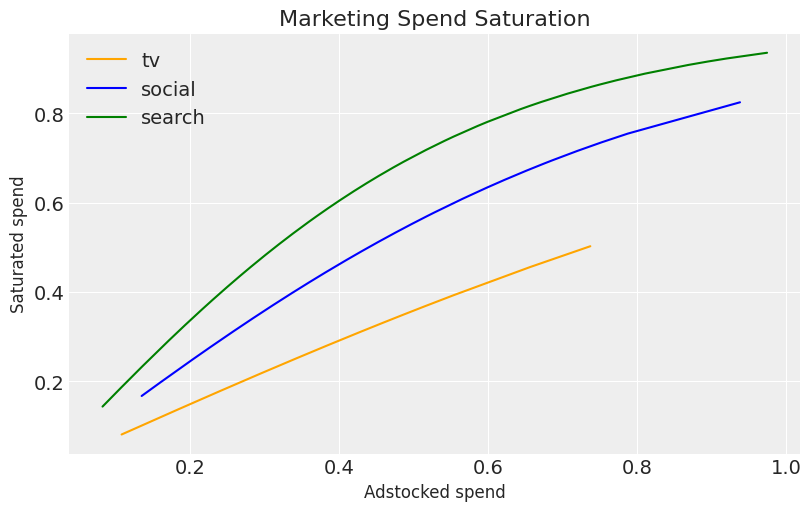

In [12]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['tv_adstock'], y=df['tv_saturated'], label=channels[0], color="orange")
sns.lineplot(x=df['social_adstock'], y=df['social_saturated'], label=channels[1], color="blue")
sns.lineplot(x=df['search_adstock'], y=df['search_saturated'], label=channels[2], color="green")

plt.title('Marketing Spend Saturation', fontsize=16)
plt.xlabel('Adstocked spend', fontsize=12)
plt.ylabel('Saturated spend', fontsize=12)
plt.legend()
plt.show()

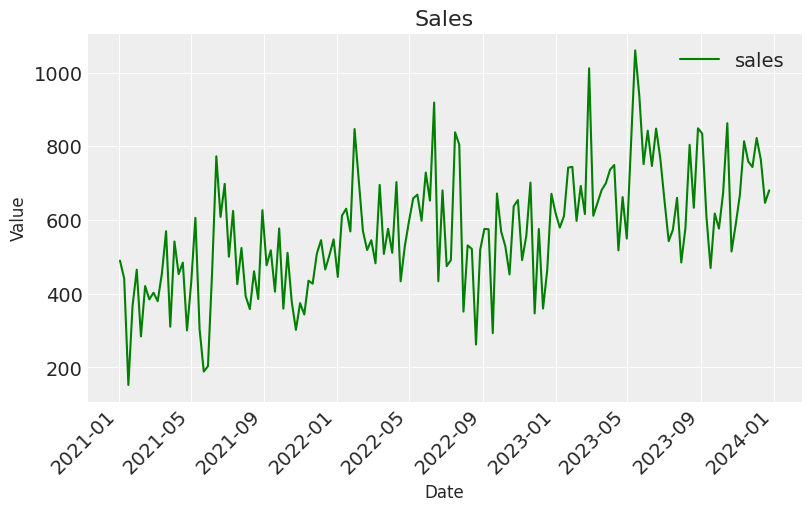

In [13]:
plt.figure(figsize=(8, 5))

sns.lineplot(x=df['date'], y=df['sales'], label="sales", color="green")

plt.title('Sales', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

# 1) Understanding the model and default priors

In [26]:
dummy_model = MMM(
    date_column="",
    channel_columns=[""],
    adstock=GeometricAdstock(l_max=4),
    saturation=LogisticSaturation(),
)
dummy_model.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

### Intercept

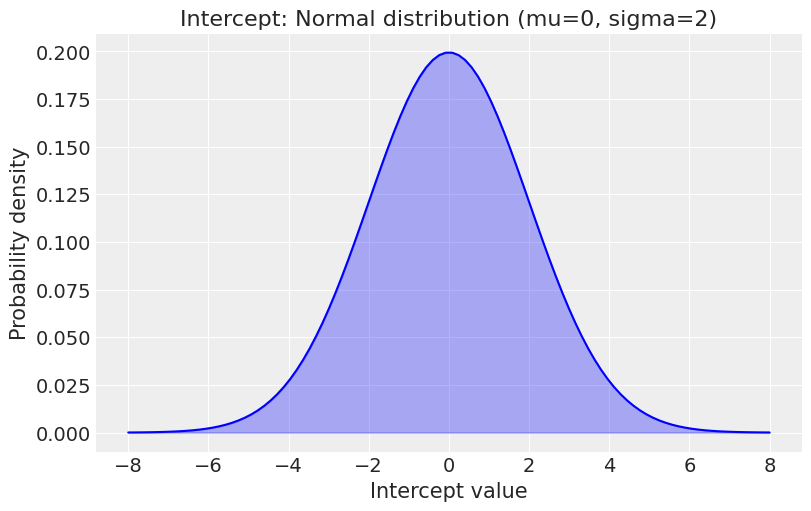

In [15]:
mu = 0
sigma = 2

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
y = norm.pdf(x, mu, sigma)

plt.figure(figsize=(8, 5))
plt.plot(x, y, color='blue')
plt.fill_between(x, y, color='blue', alpha=0.3)
plt.title('Intercept: Normal distribution (mu=0, sigma=2)')
plt.xlabel('Intercept value')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

### Control

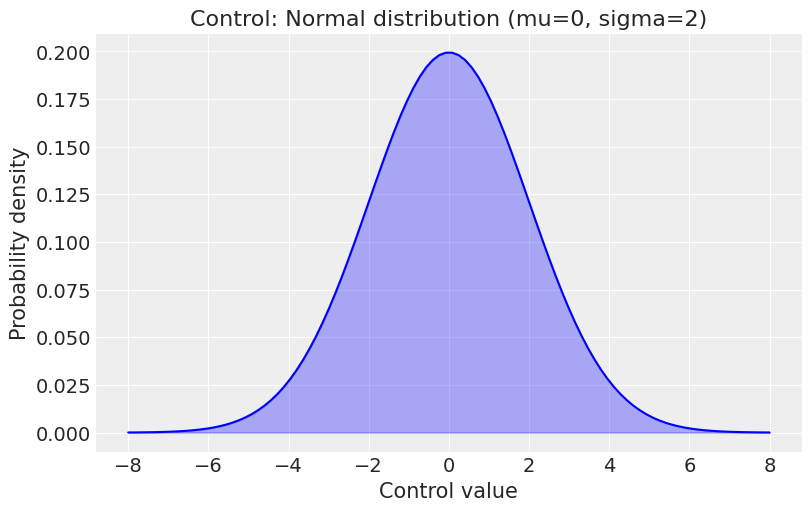

In [16]:
mu = 0
sigma = 2

x = np.linspace(mu - 4*sigma, mu + 4*sigma, 100)
y = norm.pdf(x, mu, sigma)

plt.figure(figsize=(8, 5))
plt.plot(x, y, color='blue')
plt.fill_between(x, y, color='blue', alpha=0.3)
plt.title('Control: Normal distribution (mu=0, sigma=2)')
plt.xlabel('Control value')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

### Seasonality

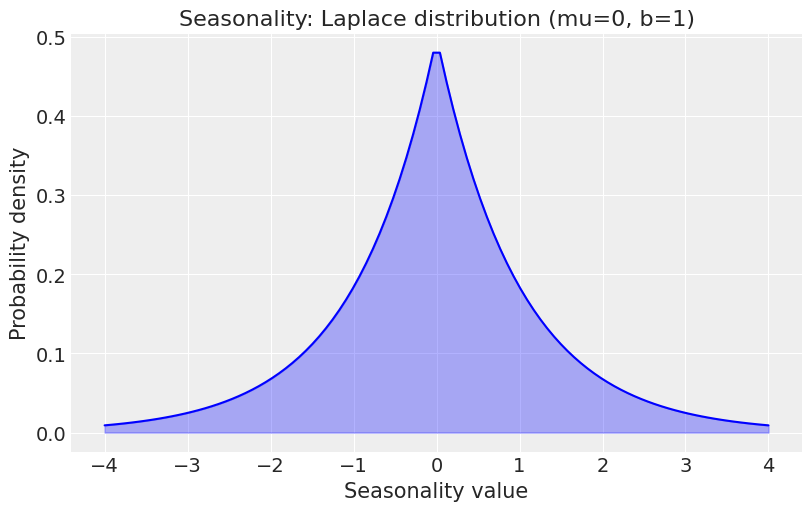

In [17]:
mu = 0
b = 1

x = np.linspace(mu - 4*b, mu + 4*b, 100)
y = laplace.pdf(x, mu, b)

plt.figure(figsize=(8, 5))
plt.plot(x, y, color='blue')
plt.fill_between(x, y, color='blue', alpha=0.3)
plt.title('Seasonality: Laplace distribution (mu=0, b=1)')
plt.xlabel('Seasonality value')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()


### Geometric adstock

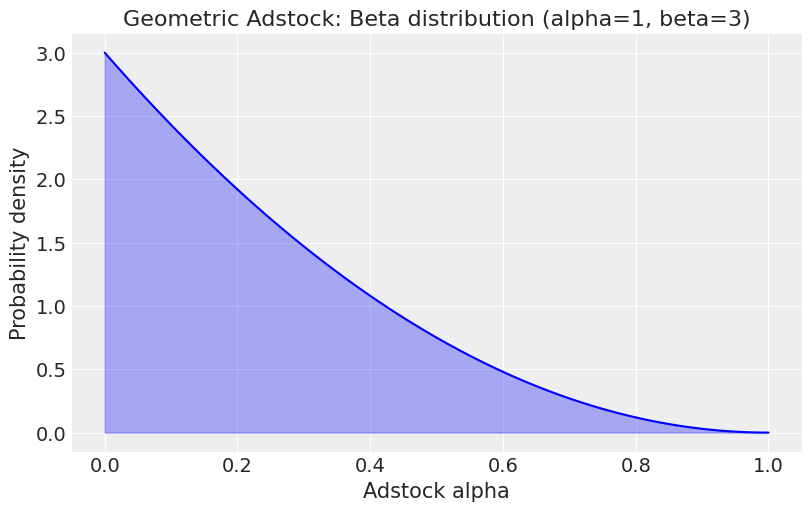

In [18]:
alpha = 1
beta_param = 3

x1 = np.linspace(0, 1, 100)
y1 = beta.pdf(x1, alpha, beta_param)

plt.figure(figsize=(8, 5))
plt.plot(x1, y1, color='blue')
plt.fill_between(x1, y1, color='blue', alpha=0.3)
plt.title('Geometric Adstock: Beta distribution (alpha=1, beta=3)')
plt.xlabel('Adstock alpha')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

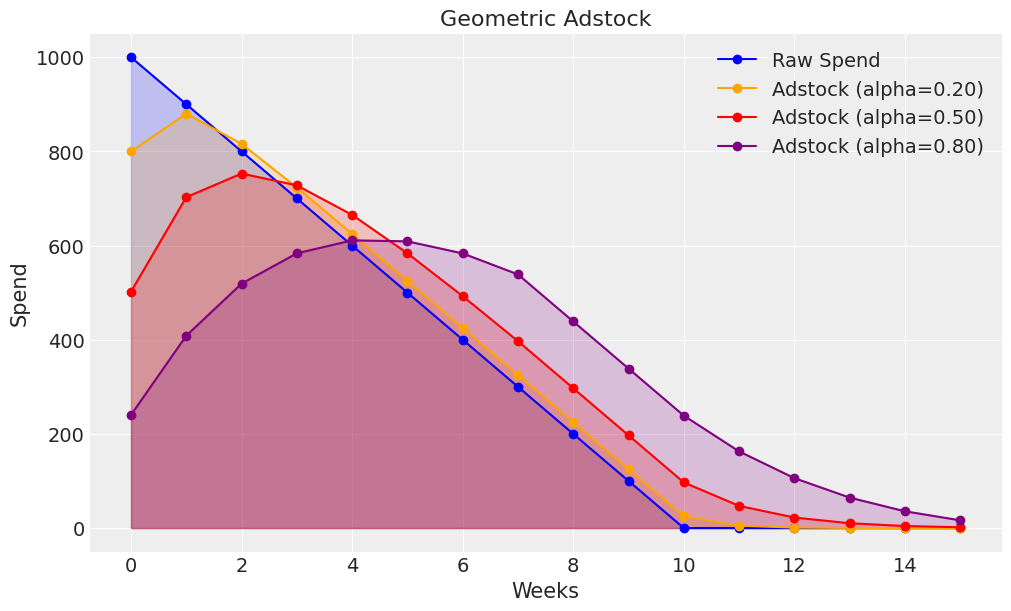

In [19]:
raw_spend = np.array([1000, 900, 800, 700, 600, 500, 400, 300, 200, 100, 0, 0, 0, 0, 0, 0])

adstock_spend_1 = geometric_adstock(x=raw_spend, alpha=0.20, l_max=8, normalize=True).eval().flatten()
adstock_spend_2 = geometric_adstock(x=raw_spend, alpha=0.50, l_max=8, normalize=True).eval().flatten()
adstock_spend_3 = geometric_adstock(x=raw_spend, alpha=0.80, l_max=8, normalize=True).eval().flatten()

plt.figure(figsize=(10, 6))

plt.plot(raw_spend, marker='o', label='Raw Spend', color='blue')
plt.fill_between(range(len(raw_spend)), 0, raw_spend, color='blue', alpha=0.2)

plt.plot(adstock_spend_1, marker='o', label='Adstock (alpha=0.20)', color='orange')
plt.fill_between(range(len(adstock_spend_1)), 0, adstock_spend_1, color='orange', alpha=0.2)

plt.plot(adstock_spend_2, marker='o', label='Adstock (alpha=0.50)', color='red')
plt.fill_between(range(len(adstock_spend_2)), 0, adstock_spend_2, color='red', alpha=0.2)

plt.plot(adstock_spend_3, marker='o', label='Adstock (alpha=0.80)', color='purple')
plt.fill_between(range(len(adstock_spend_3)), 0, adstock_spend_3, color='purple', alpha=0.2)

plt.xlabel('Weeks')
plt.ylabel('Spend')
plt.title('Geometric Adstock')
plt.legend()
plt.grid(True)
plt.show()


### Logistic saturation

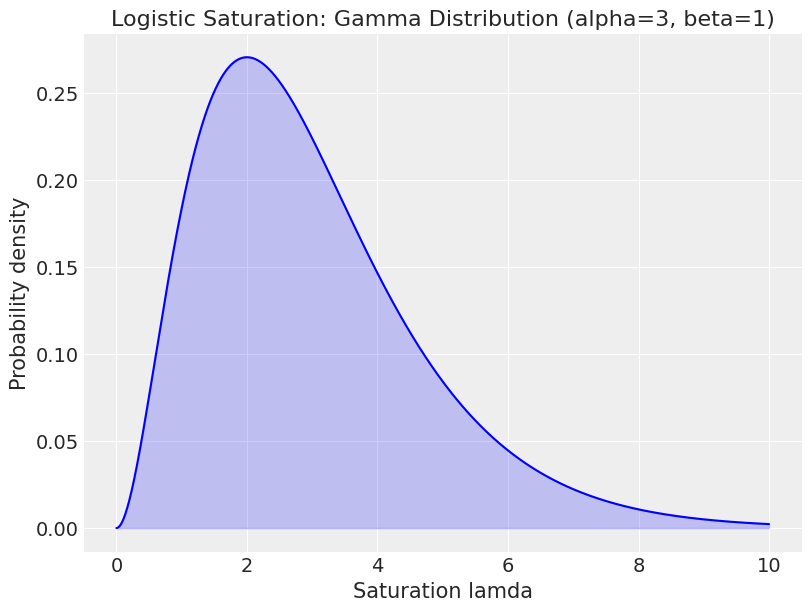

In [20]:
alpha = 3
beta = 1

x2 = np.linspace(0, 10, 1000)
y2 = gamma.pdf(x2, alpha, scale=1/beta)

plt.figure(figsize=(8, 6))
plt.plot(x2, y2, 'b-')
plt.fill_between(x2, y2, alpha=0.2, color='blue')
plt.title('Logistic Saturation: Gamma Distribution (alpha=3, beta=1)')
plt.xlabel('Saturation lamda')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

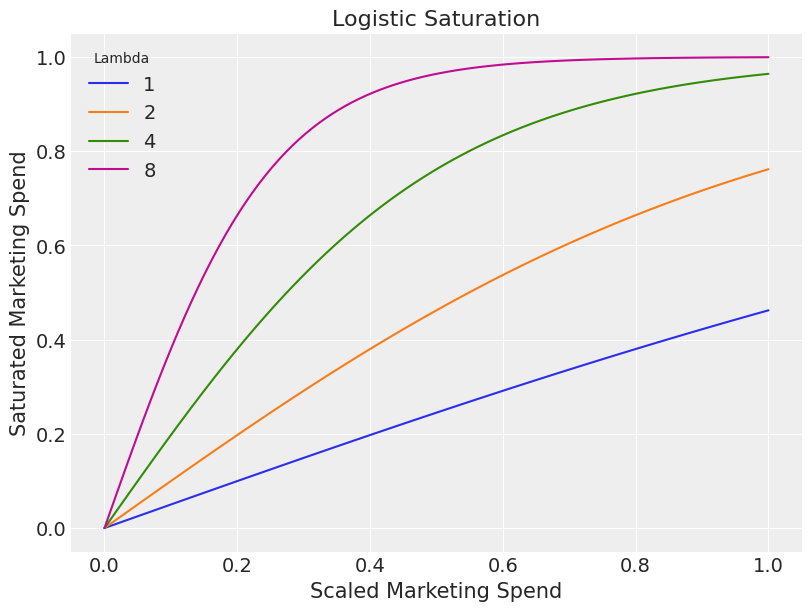

In [21]:
scaled_spend = np.linspace(start=0.0, stop=1.0, num=100)

saturated_spend_1 = logistic_saturation(x=scaled_spend, lam=1).eval()
saturated_spend_2 = logistic_saturation(x=scaled_spend, lam=2).eval()
saturated_spend_4 = logistic_saturation(x=scaled_spend, lam=4).eval()
saturated_spend_8 = logistic_saturation(x=scaled_spend, lam=8).eval()

plt.figure(figsize=(8, 6))
sns.lineplot(x=scaled_spend, y=saturated_spend_1, label="1")
sns.lineplot(x=scaled_spend, y=saturated_spend_2, label="2")
sns.lineplot(x=scaled_spend, y=saturated_spend_4, label="4")
sns.lineplot(x=scaled_spend, y=saturated_spend_8, label="8")

plt.title('Logistic Saturation')
plt.xlabel('Scaled Marketing Spend')
plt.ylabel('Saturated Marketing Spend')
plt.legend(title='Lambda')
plt.grid(True)
plt.show()

### Saturation beta

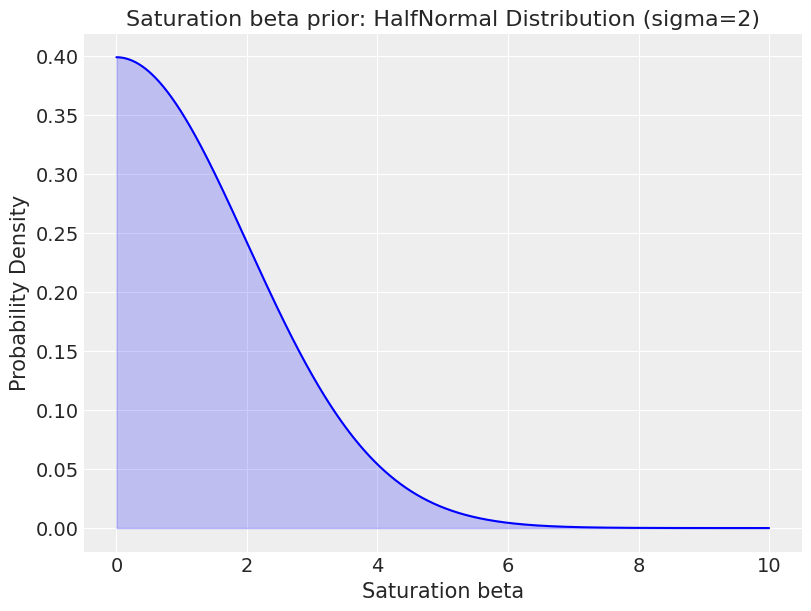

In [22]:
sigma = 2

x3 = np.linspace(0, 10, 1000)
y3 = halfnorm.pdf(x3, scale=sigma)

plt.figure(figsize=(8, 6))
plt.plot(x3, y3, 'b-')
plt.fill_between(x3, y3, alpha=0.2, color='blue')
plt.title('Saturation beta prior: HalfNormal Distribution (sigma=2)')
plt.xlabel('Saturation beta')
plt.ylabel('Probability Density')
plt.grid(True)
plt.show()

# 2) Fit model

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              156 non-null    datetime64[ns]
 1   trend             156 non-null    float64       
 2   seasonality       156 non-null    float64       
 3   demand            156 non-null    float64       
 4   demand_proxy      156 non-null    float64       
 5   sales             156 non-null    float64       
 6   tv_spend_raw      156 non-null    float64       
 7   tv_spend          156 non-null    float64       
 8   tv_adstock        156 non-null    float64       
 9   tv_saturated      156 non-null    float64       
 10  tv_sales          156 non-null    float64       
 11  social_spend_raw  156 non-null    float64       
 12  social_spend      156 non-null    float64       
 13  social_adstock    156 non-null    float64       
 14  social_saturated  156 non-

In [5]:
# set date column
date_col = "date"

# set outcome column
y_col = "sales"

# set marketing variables
channel_cols = ["tv_spend_raw",
                "social_spend_raw",
                "search_spend_raw"]

# set control variables
control_cols = ["demand_proxy"]

# create arrays
X = df[[date_col] + channel_cols + control_cols]
y = df[y_col]

# set test (out-of-sample) length
test_len = 8

# create train and test indexs
train_idx = slice(0, len(df) - test_len)
out_of_time_idx = slice(len(df) - test_len, len(df))

In [6]:
mmm_default = MMM(
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
    date_column=date_col,
    channel_columns=channel_cols,
    control_columns=control_cols,
)

mmm_default.default_model_config

{'intercept': Prior("Normal", mu=0, sigma=2),
 'likelihood': Prior("Normal", sigma=Prior("HalfNormal", sigma=2)),
 'gamma_control': Prior("Normal", mu=0, sigma=2, dims="control"),
 'gamma_fourier': Prior("Laplace", mu=0, b=1, dims="fourier_mode"),
 'adstock_alpha': Prior("Beta", alpha=1, beta=3, dims="channel"),
 'saturation_lam': Prior("Gamma", alpha=3, beta=1, dims="channel"),
 'saturation_beta': Prior("HalfNormal", sigma=2, dims="channel")}

In [7]:
fit_kwargs = {
    "tune": 1_000,
    "chains": 4,
    "draws": 1_000,
    "target_accept": 0.9,
}

mmm_default.fit(X[train_idx], y[train_idx], **fit_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, gamma_control, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 198 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [23]:
mmm_default.save("mmm_default.nc")

# 3) Validate model

In [8]:
mmm_default.idata["sample_stats"]["diverging"].sum().item()

0

In [9]:
az.summary(
    data=mmm_default.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
intercept                         -0.008  0.019  -0.045    0.027      0.000   
y_sigma                            0.028  0.002   0.025    0.031      0.000   
saturation_beta[tv_spend_raw]      0.634  0.374   0.258    1.256      0.011   
saturation_beta[social_spend_raw]  0.193  0.031   0.142    0.242      0.001   
saturation_beta[search_spend_raw]  0.125  0.075   0.041    0.232      0.003   
saturation_lam[tv_spend_raw]       1.692  0.779   0.334    3.066      0.018   
saturation_lam[social_spend_raw]   3.796  0.958   2.042    5.620      0.020   
saturation_lam[search_spend_raw]   2.825  1.308   0.348    4.962      0.035   
adstock_alpha[tv_spend_raw]        0.405  0.056   0.293    0.502      0.001   
adstock_alpha[social_spend_raw]    0.097  0.060   0.000    0.198      0.001   
adstock_alpha[search_spend_raw]    0.084  0.082   0.000    0.233      0.001   
gamma_control[demand_proxy]        0.001  0.000   0.001    0.001      0.000   

                                   mcse_sd  ess_bulk  ess_tail  r_hat  
intercept                            0.000    2566.0    2303.0    1.0  
y_sigma                              0.000    3476.0    2689.0    1.0  
saturation_beta[tv_spend_raw]        0.008    1573.0    1399.0    1.0  
saturation_beta[social_spend_raw]    0.001    2159.0    1442.0    1.0  
saturation_beta[search_spend_raw]    0.002    1120.0     842.0    1.0  
saturation_lam[tv_spend_raw]         0.013    1530.0    1477.0    1.0  
saturation_lam[social_spend_raw]     0.014    2323.0    1414.0    1.0  
saturation_lam[search_spend_raw]     0.024    1276.0     951.0    1.0  
adstock_alpha[tv_spend_raw]          0.001    2589.0    1795.0    1.0  
adstock_alpha[social_spend_raw]      0.001    2130.0    1297.0    1.0  
adstock_alpha[search_spend_raw]      0.001    2857.0    1765.0    1.0  
gamma_control[demand_proxy]          0.000    2909.0    2925.0    1.0

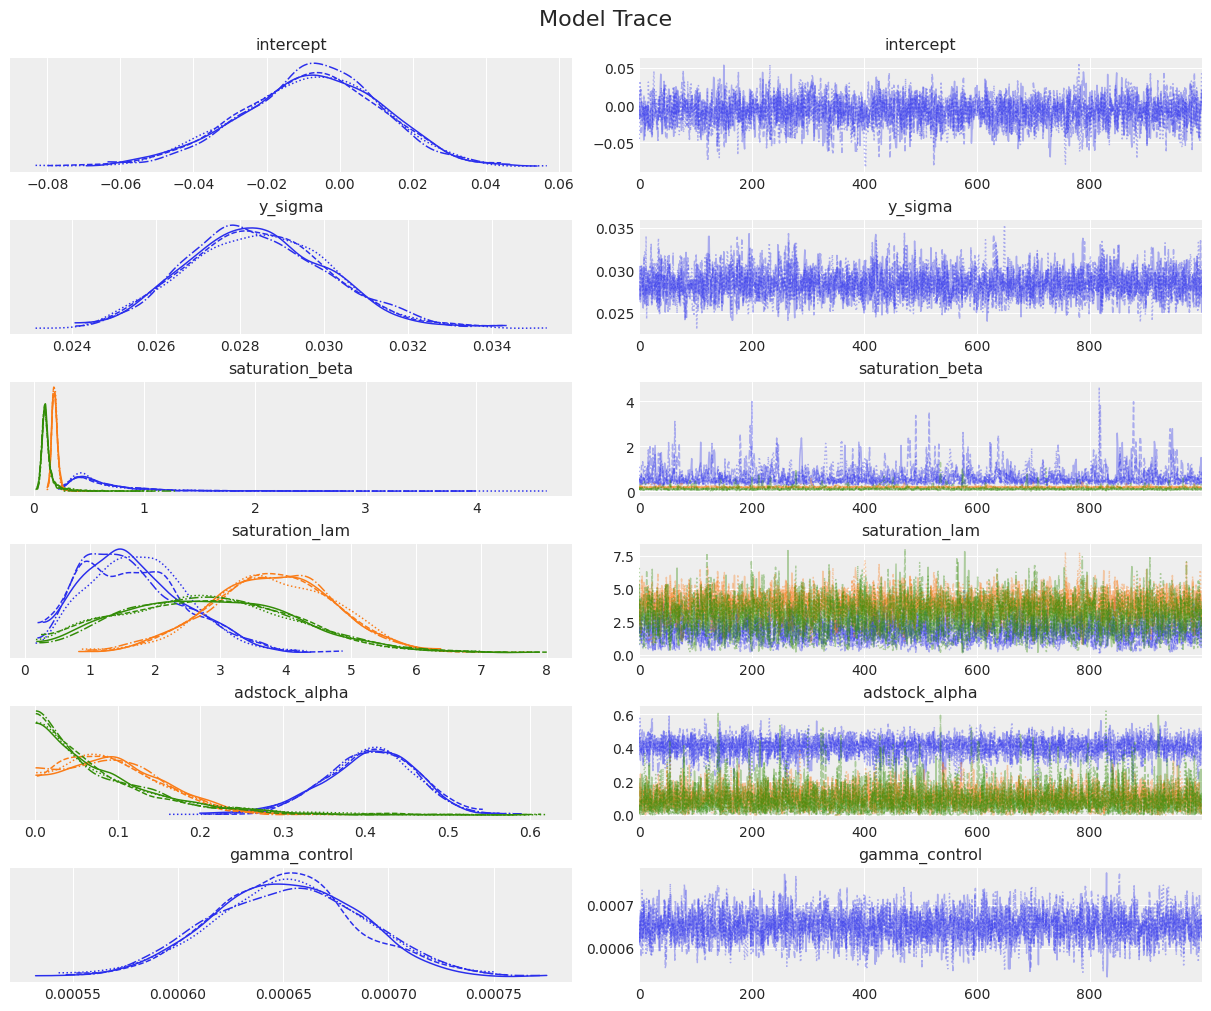

In [10]:
_ = az.plot_trace(
    data=mmm_default.fit_result,
    var_names=[
        "intercept",
        "y_sigma",
        "saturation_beta",
        "saturation_lam",
        "adstock_alpha",
        "gamma_control",
    ],
    compact=True,
    backend_kwargs={"figsize": (12, 10), "layout": "constrained"},
)
plt.gcf().suptitle("Model Trace", fontsize=16);

In [11]:
mmm_default.sample_posterior_predictive(X[train_idx], extend_idata=True, combined=True)

Sampling: [y]


Output()

<xarray.Dataset> Size: 5MB
Dimensions:  (sample: 4000, date: 148)
Coordinates:
  * date     (date) datetime64[ns] 1kB 2021-01-03 2021-01-10 ... 2023-10-29
  * sample   (sample) object 32kB MultiIndex
  * chain    (sample) int32 16kB 0 0 0 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3 3 3 3
  * draw     (sample) int32 16kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
Data variables:
    y        (date, sample) float64 5MB 533.0 459.6 495.1 ... 626.3 546.6 545.4
Attributes:
    created_at:                 2024-09-30T10:11:29.110612+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

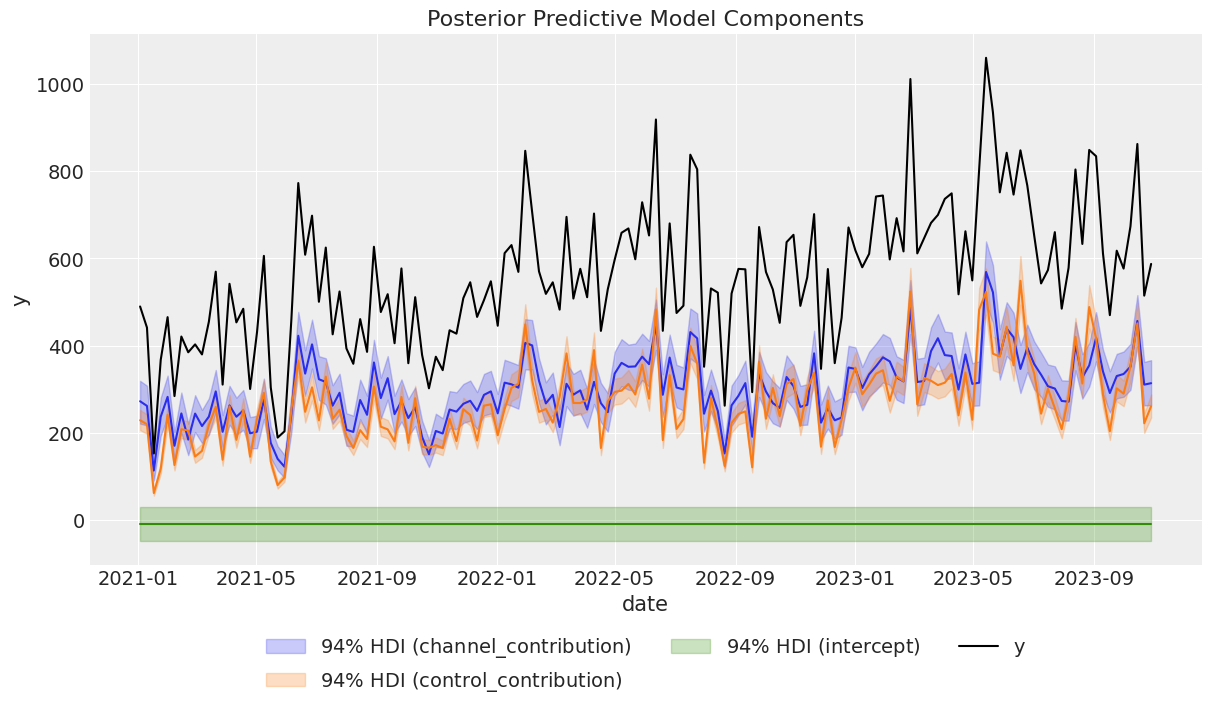

In [12]:
mmm_default.plot_components_contributions(original_scale=True);

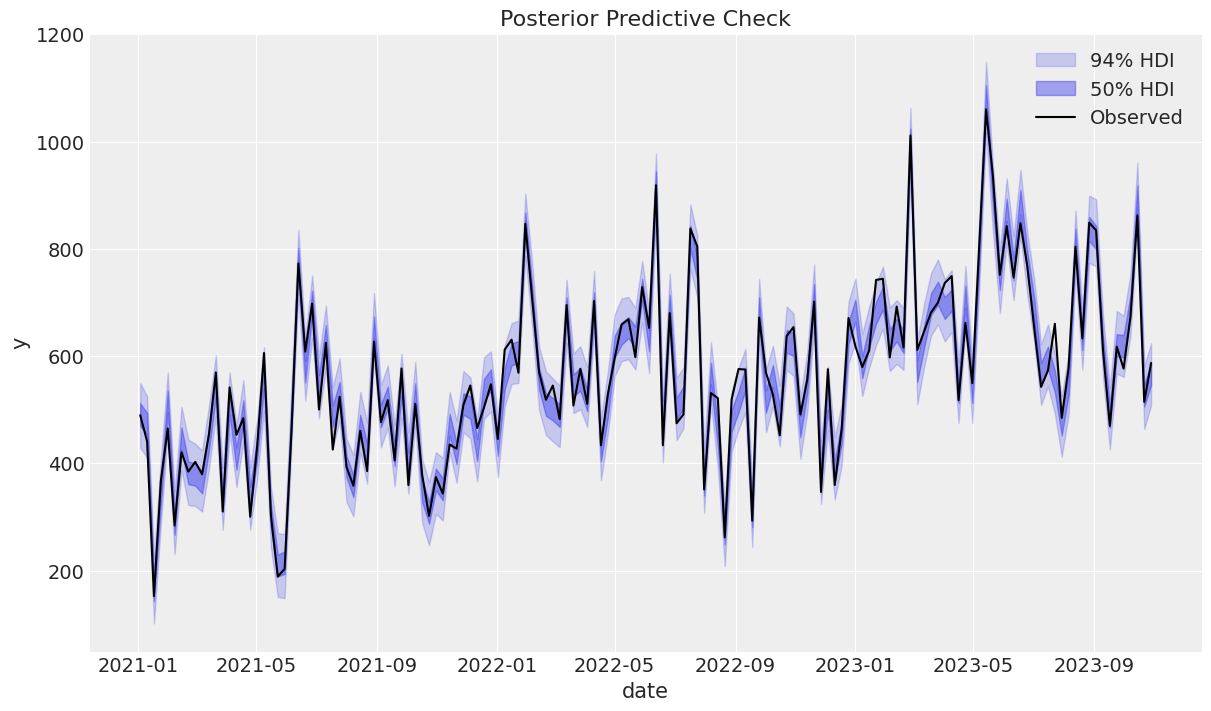

In [13]:
mmm_default.plot_posterior_predictive(original_scale=True);

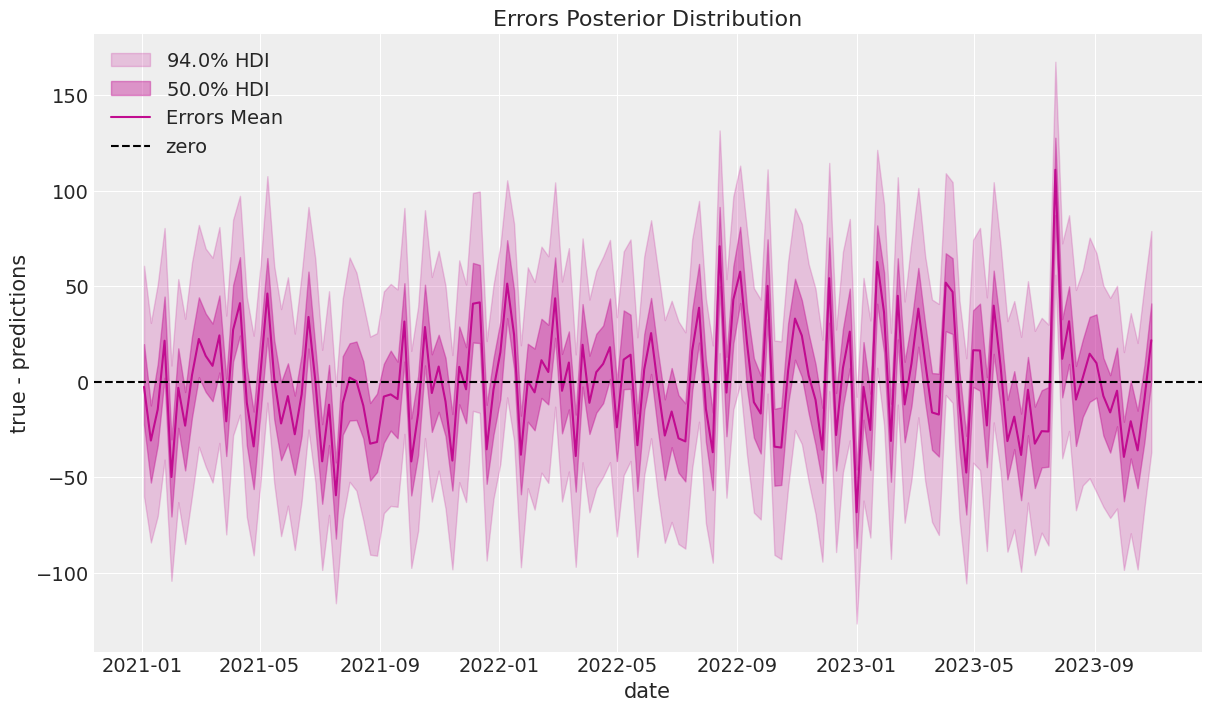

In [14]:
mmm_default.plot_errors(original_scale=True);

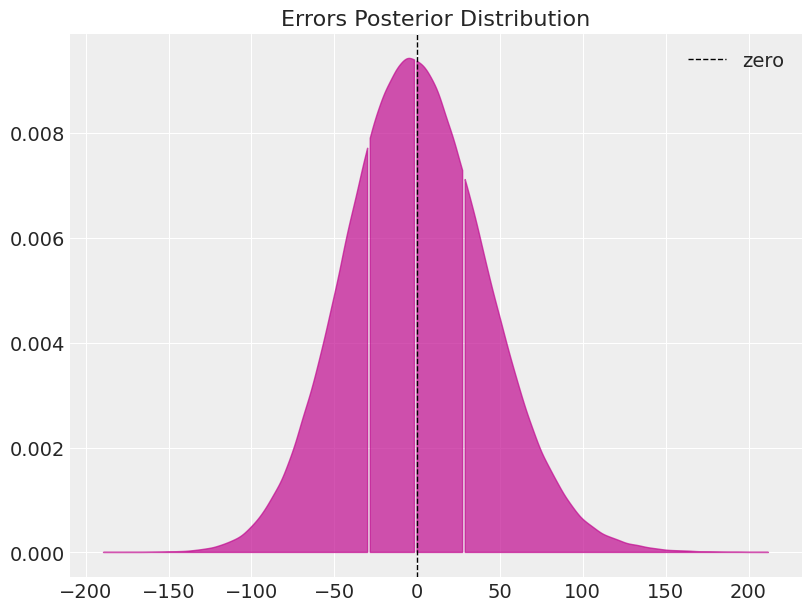

In [15]:
errors = mmm_default.get_errors(original_scale=True)

fig, ax = plt.subplots(figsize=(8, 6))
az.plot_dist(
    errors, quantiles=[0.25, 0.5, 0.75], color="C3", fill_kwargs={"alpha": 0.7}, ax=ax
)
ax.axvline(x=0, color="black", linestyle="--", linewidth=1, label="zero")
ax.legend()
ax.set(title="Errors Posterior Distribution");

Sampling: [y]


Output()

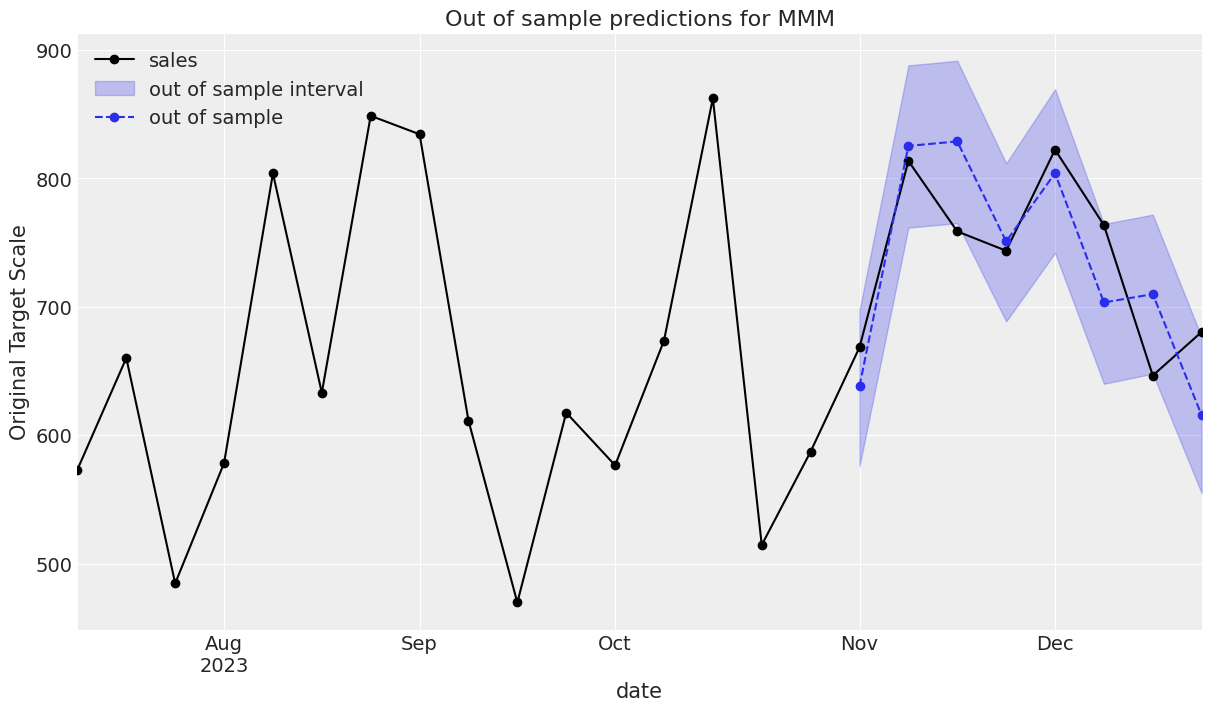

In [16]:
y_out_of_sample = mmm_default.sample_posterior_predictive(
    X_pred=X[out_of_time_idx], extend_idata=False, include_last_observations=True
)

def plot_in_sample(X, y, ax, n_points: int = 15):
    (
        y.to_frame()
        .set_index(X[date_col])
        .iloc[-n_points:]
        .plot(ax=ax, marker="o", color="black", label="actuals")
    )
    return ax


def plot_out_of_sample(X_out_of_sample, y_out_of_sample, ax, color, label):
    y_out_of_sample_groupby = y_out_of_sample["y"].to_series().groupby("date")

    lower, upper = quantiles = [0.025, 0.975]
    conf = y_out_of_sample_groupby.quantile(quantiles).unstack()
    ax.fill_between(
        X_out_of_sample[date_col].dt.to_pydatetime(),
        conf[lower],
        conf[upper],
        alpha=0.25,
        color=color,
        label=f"{label} interval",
    )

    mean = y_out_of_sample_groupby.mean()
    mean.plot(ax=ax, marker="o", label=label, color=color, linestyle="--")
    ax.set(ylabel="Original Target Scale", title="Out of sample predictions for MMM")
    return ax


_, ax = plt.subplots()
plot_in_sample(X, y, ax=ax, n_points=len(X[out_of_time_idx])*3)
plot_out_of_sample(
    X[out_of_time_idx], y_out_of_sample, ax=ax, label="out of sample", color="C0"
)
ax.legend(loc="upper left");

# 4) Parameter validation - Adstock

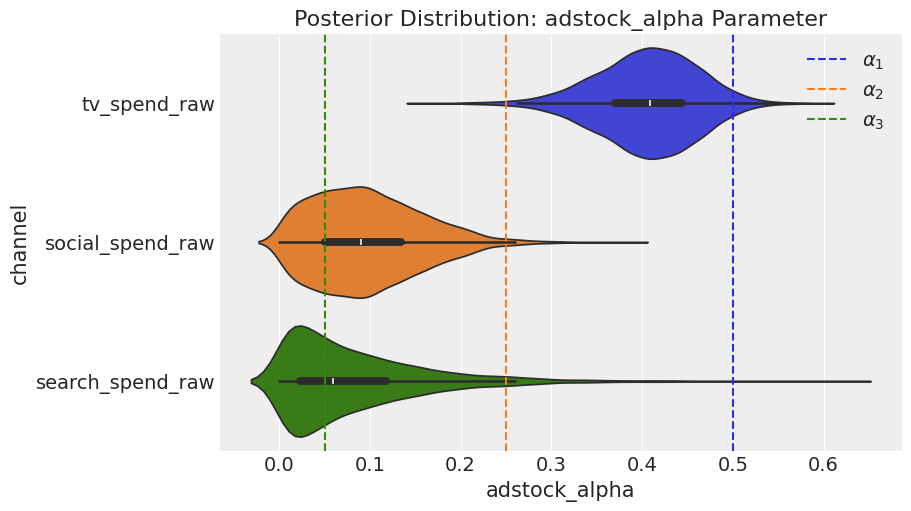

In [17]:
fig = mmm_default.plot_channel_parameter(param_name="adstock_alpha", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=adstock_alphas[0], color="C0", linestyle="--", label=r"$\alpha_1$")
ax.axvline(x=adstock_alphas[1], color="C1", linestyle="--", label=r"$\alpha_2$")
ax.axvline(x=adstock_alphas[2], color="C2", linestyle="--", label=r"$\alpha_3$")
ax.legend(loc="upper right");

# 5) Parameter validation - Saturation

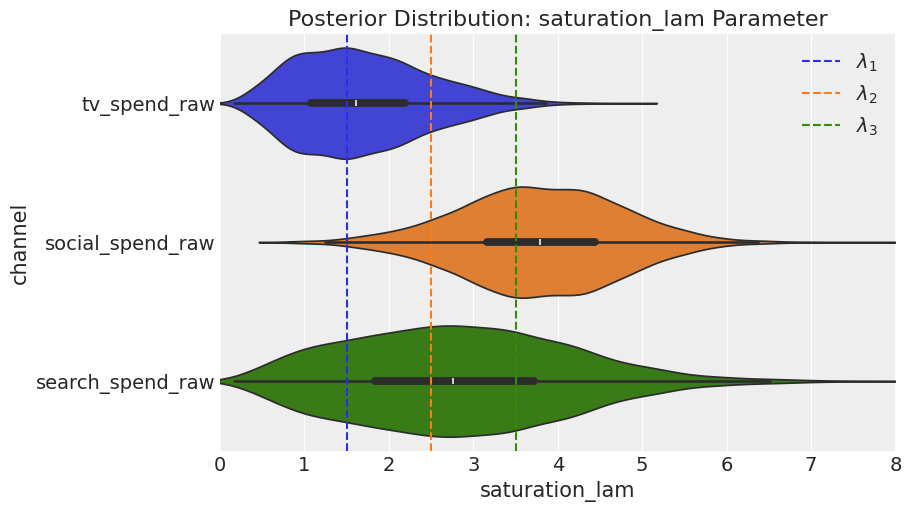

In [18]:
fig = mmm_default.plot_channel_parameter(param_name="saturation_lam", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=saturation_lamdas[0], color="C0", linestyle="--", label=r"$\lambda_1$")
ax.axvline(x=saturation_lamdas[1], color="C1", linestyle="--", label=r"$\lambda_2$")
ax.axvline(x=saturation_lamdas[2], color="C2", linestyle="--", label=r"$\lambda_3$")
ax.set_xlim([0, 8])
ax.legend(loc="upper right");

# 6) Parameter validation - Channel betas

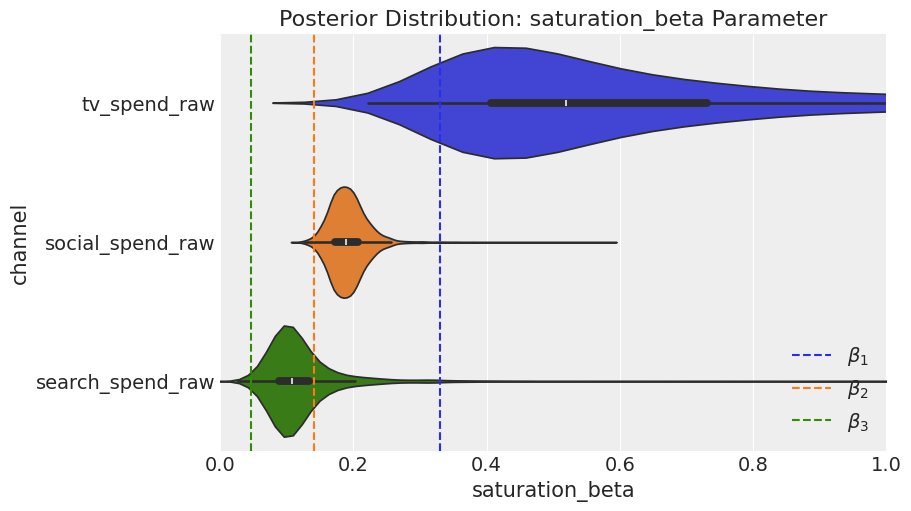

In [19]:
fig = mmm_default.plot_channel_parameter(param_name="saturation_beta", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=betas_scaled[0], color="C0", linestyle="--", label=r"$\beta_1$")
ax.axvline(x=betas_scaled[1], color="C1", linestyle="--", label=r"$\beta_2$")
ax.axvline(x=betas_scaled[2], color="C2", linestyle="--", label=r"$\beta_3$")
ax.set_xlim([0, 1])
ax.legend(loc="lower right");

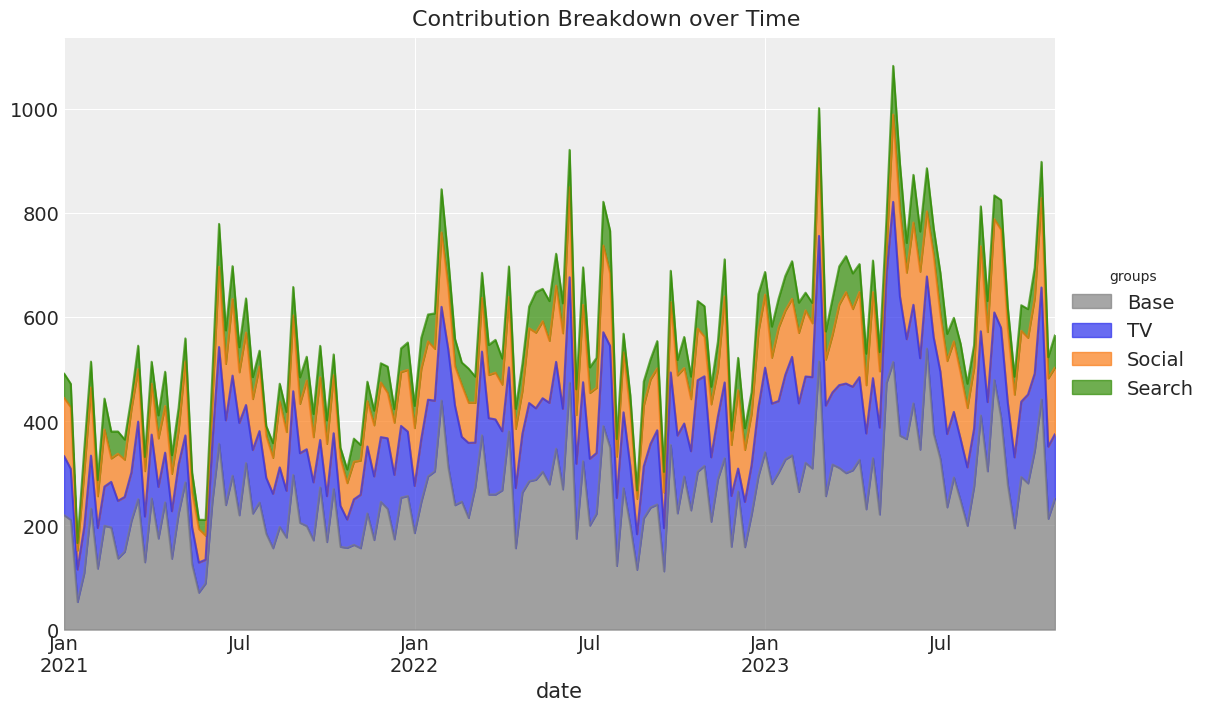

In [20]:
groups = {
    "Base": [
        "intercept",
        "demand_proxy",
    ],
    "TV": ["tv_spend_raw"],
    "Social": ["social_spend_raw"],
    "Search": ["search_spend_raw"],
}

fig = mmm_default.plot_grouped_contribution_breakdown_over_time(
    stack_groups=groups,
    original_scale=True,
    area_kwargs={
        "color": {
            "TV": "C0",
            "Social": "C1",
            "Search": "C2",            
            "Base": "gray",
        },
        "alpha": 0.7,
    },
)

fig.suptitle("Contribution Breakdown over Time", fontsize=16);

In [21]:
channels = np.array(["tv", "social", "search", "demand"])

true_contributions = pd.DataFrame({'Channels': channels, 'Contributions': contributions})
true_contributions= true_contributions.sort_values(by='Contributions', ascending=False).reset_index(drop=True)
true_contributions = true_contributions.style.bar(subset=['Contributions'], color='lightblue')

true_contributions

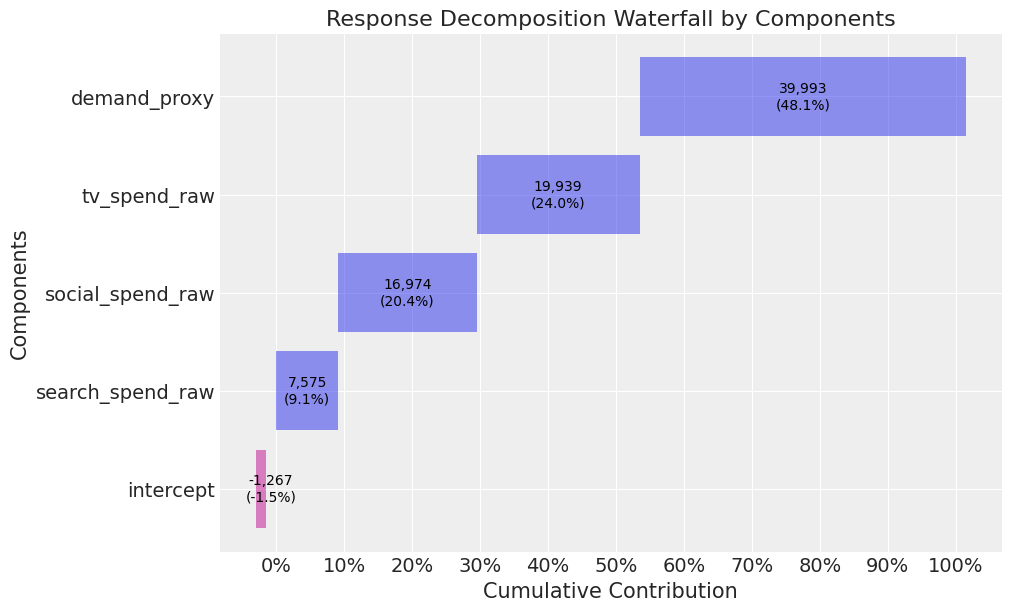

In [22]:
mmm_default.plot_waterfall_components_decomposition(figsize=(10,6));